In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [12]:
import os
import cv2
import time
import torch
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from torch.nn import ReLU
from torch.nn import Conv2d
from torch.nn import Module
from torch.nn import MaxPool2d
from torch.nn import ModuleList
from torch.nn import BatchNorm2d
from torch.nn import ConvTranspose2d
from torch.nn import BCEWithLogitsLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import CenterCrop
from sklearn.model_selection import train_test_split
from torchvision import transforms

In [ ]:
dataset_path = "/mydrive/Lab-Hooshman/interactive/dataset"

In [ ]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		return len(self.imagePaths)
	def __getitem__(self, idx):
		imagePath = self.imagePaths[idx]
		image = Image.open(self.imagePaths[idx]).convert('L')
		mask = Image.open(self.maskPaths[idx]).convert('L')
		mask = mask.point(lambda p: 255 if p > 45 else 0 ).convert('1')
		if self.transforms is not None:
			image = self.transforms(image)
			mask = self.transforms(mask)
		return (image, mask)

In [ ]:
DATASET_PATH = os.path.join(dataset_path, "train")
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
TEST_SPLIT = 0.15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = DEVICE == "cuda"
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

INIT_LR = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 128

INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

THRESHOLD = 0.5

BASE_OUTPUT = os.path.join(dataset_path, "output")
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
PLOT_PATH_PREDICTION = os.path.sep.join([BASE_OUTPUT, "prediction.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
TRAIN_PATHS = os.path.join(BASE_OUTPUT, "train_paths.txt")

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print('start preparing data ...')

def get_image_paths(dataset_folder, image_extension="*.png"):
    return glob(os.path.join(dataset_folder, image_extension))

def derive_mask_path(image_path):
    return image_path.replace("images", "masks")


image_paths = get_image_paths(os.path.join(DATASET_PATH, 'images'))


mask_paths = [derive_mask_path(image_path) for image_path in image_paths]

trainImages, testImages, trainMasks, testMasks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=SEED)

trans = transforms.Compose([transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                            transforms.ToTensor()])

trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=trans)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=trans)

trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False, batch_size=1, pin_memory=PIN_MEMORY)

print(f'number of training data: {len(trainDS)}')
print(f'number of testing data: {len(testDS)}')

start preparing data ...
number of training data: 476
number of testing data: 119


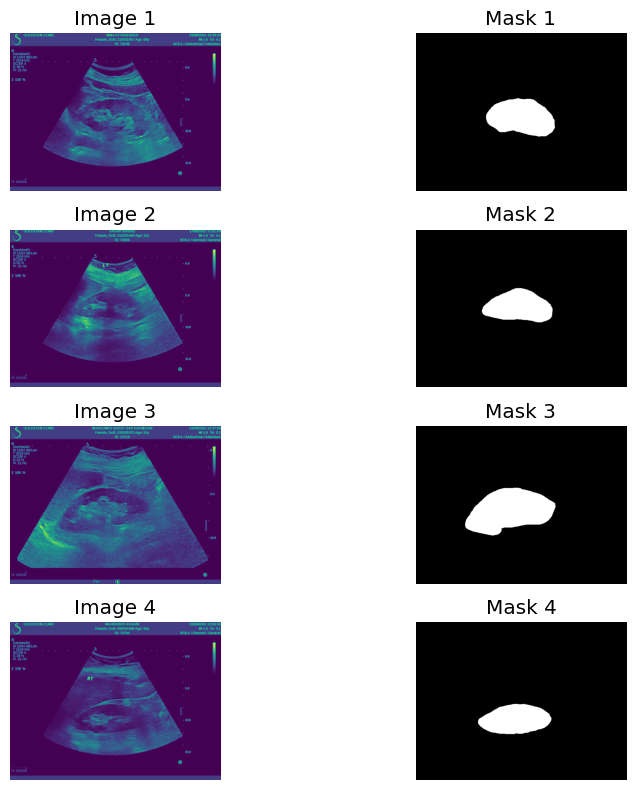

In [ ]:
def visualize_images_with_masks(image_paths, mask_paths, num_images=5):
    selected_indices = random.sample(range(len(image_paths)), num_images)

    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

    for i, idx in enumerate(selected_indices):
        image = Image.open(image_paths[idx])
        mask = Image.open(mask_paths[idx])

        image = np.array(image)
        mask = np.array(mask)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_with_masks(trainImages, trainMasks, num_images=4)

In [ ]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.batchnorm1 = BatchNorm2d(outChannels)
        self.relu1 = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
        self.batchnorm2 = BatchNorm2d(outChannels)
        self.relu2 = ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        return x

class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        return blockOutputs

class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
             for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        for i in range(len(self.channels) - 1):
            x = self.upconvs[i](x)
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        return x
    def crop(self, encFeatures, x):
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        return encFeatures

class UNet(Module):
    def __init__(self,
                 encChannels=(1, 16, 32, 64),
                 decChannels=(64, 32, 16),
                 nbClasses=1,
                 retainDim=True,
                 outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        map = self.head(decFeatures)
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        return map

In [ ]:
def iou(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > 0.5

    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    return intersection / union if union != 0 else torch.tensor(0.0)

def dice_coeff(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > 0.5

    intersection = torch.sum(pred * target)
    return (2. * intersection) / (torch.sum(pred) + torch.sum(target) + 1e-6)

In [ ]:
unet = UNet().to(DEVICE)

lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
H = {"train_loss": [], "test_loss": []}

In [ ]:
import time
from tqdm import tqdm

H["train_iou"] = []
H["test_iou"] = []
H["train_dice"] = []
H["test_dice"] = []

print("[INFO] training the network...")
startTime = time.time()

trainSteps = len(trainLoader)
testSteps = len(testLoader)
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()

    totalTrainLoss = 0
    totalTestLoss = 0
    totalTrainIoU = 0
    totalTestIoU = 0
    totalTrainDice = 0
    totalTestDice = 0

    for index, (x, y) in enumerate(trainLoader):
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        pred = unet(x)
        loss = lossFunc(pred, y)

        opt.zero_grad()

        loss.backward()
        opt.step()

        totalTrainLoss += loss.item()

        totalTrainIoU += iou(pred, y).item()
        totalTrainDice += dice_coeff(pred, y).item()

    with torch.no_grad():
        unet.eval()

        for (x, y) in testLoader:
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            pred = unet(x)
            totalTestLoss += lossFunc(pred, y).item()

            totalTestIoU += iou(pred, y).item()
            totalTestDice += dice_coeff(pred, y).item()

    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    avgTrainIoU = totalTrainIoU / trainSteps
    avgTestIoU = totalTestIoU / testSteps
    avgTrainDice = totalTrainDice / trainSteps
    avgTestDice = totalTestDice / testSteps

    H["train_loss"].append(avgTrainLoss)
    H["test_loss"].append(avgTestLoss)
    H["train_iou"].append(avgTrainIoU)
    H["test_iou"].append(avgTestIoU)
    H["train_dice"].append(avgTrainDice)
    H["test_dice"].append(avgTestDice)

    print(f"[INFO] EPOCH: {e + 1}/{NUM_EPOCHS}")
    print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}")
    print(f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}")
    print(f"Train Dice: {avgTrainDice:.4f}, Test Dice: {avgTestDice:.4f}")

    endTime = time.time()
    print(f"[INFO] total time taken to train the model: {endTime - startTime:.2f}s")

[INFO] training the network...


  1%|          | 1/100 [00:13<21:35, 13.08s/it]

[INFO] EPOCH: 1/100
Train loss: 0.773755, Test loss: 0.7985
Train IoU: 0.0601, Test IoU: 0.0000
Train Dice: 0.1133, Test Dice: 0.0000
[INFO] total time taken to train the model: 13.09s


  2%|▏         | 2/100 [00:24<19:35, 11.99s/it]

[INFO] EPOCH: 2/100
Train loss: 0.756003, Test loss: 0.8011
Train IoU: 0.0718, Test IoU: 0.0000
Train Dice: 0.1340, Test Dice: 0.0000
[INFO] total time taken to train the model: 24.32s


  3%|▎         | 3/100 [00:34<18:23, 11.37s/it]

[INFO] EPOCH: 3/100
Train loss: 0.741826, Test loss: 0.7983
Train IoU: 0.0774, Test IoU: 0.0000
Train Dice: 0.1437, Test Dice: 0.0000
[INFO] total time taken to train the model: 34.96s


  4%|▍         | 4/100 [00:46<18:00, 11.25s/it]

[INFO] EPOCH: 4/100
Train loss: 0.729576, Test loss: 0.7953
Train IoU: 0.0801, Test IoU: 0.0000
Train Dice: 0.1483, Test Dice: 0.0000
[INFO] total time taken to train the model: 46.03s


  5%|▌         | 5/100 [00:57<17:49, 11.26s/it]

[INFO] EPOCH: 5/100
Train loss: 0.718555, Test loss: 0.7854
Train IoU: 0.0848, Test IoU: 0.0000
Train Dice: 0.1563, Test Dice: 0.0000
[INFO] total time taken to train the model: 57.30s


  6%|▌         | 6/100 [01:08<17:43, 11.32s/it]

[INFO] EPOCH: 6/100
Train loss: 0.708581, Test loss: 0.7608
Train IoU: 0.0877, Test IoU: 0.0000
Train Dice: 0.1612, Test Dice: 0.0000
[INFO] total time taken to train the model: 68.72s


  7%|▋         | 7/100 [01:19<17:29, 11.29s/it]

[INFO] EPOCH: 7/100
Train loss: 0.699526, Test loss: 0.7285
Train IoU: 0.0914, Test IoU: 0.0000
Train Dice: 0.1674, Test Dice: 0.0000
[INFO] total time taken to train the model: 79.95s


  8%|▊         | 8/100 [01:30<17:01, 11.11s/it]

[INFO] EPOCH: 8/100
Train loss: 0.690783, Test loss: 0.7003
Train IoU: 0.0954, Test IoU: 0.0000
Train Dice: 0.1741, Test Dice: 0.0000
[INFO] total time taken to train the model: 90.67s


  9%|▉         | 9/100 [01:41<16:50, 11.10s/it]

[INFO] EPOCH: 9/100
Train loss: 0.682988, Test loss: 0.6883
Train IoU: 0.0958, Test IoU: 0.0012
Train Dice: 0.1749, Test Dice: 0.0025
[INFO] total time taken to train the model: 101.75s


 10%|█         | 10/100 [01:52<16:38, 11.10s/it]

[INFO] EPOCH: 10/100
Train loss: 0.674688, Test loss: 0.6848
Train IoU: 0.0971, Test IoU: 0.0073
Train Dice: 0.1771, Test Dice: 0.0144
[INFO] total time taken to train the model: 112.85s


 11%|█         | 11/100 [02:04<16:29, 11.12s/it]

[INFO] EPOCH: 11/100
Train loss: 0.667067, Test loss: 0.6828
Train IoU: 0.0988, Test IoU: 0.0227
Train Dice: 0.1798, Test Dice: 0.0436
[INFO] total time taken to train the model: 124.03s


 12%|█▏        | 12/100 [02:15<16:19, 11.13s/it]

[INFO] EPOCH: 12/100
Train loss: 0.659940, Test loss: 0.6818
Train IoU: 0.1050, Test IoU: 0.0505
Train Dice: 0.1900, Test Dice: 0.0931
[INFO] total time taken to train the model: 135.19s


 13%|█▎        | 13/100 [02:25<15:50, 10.92s/it]

[INFO] EPOCH: 13/100
Train loss: 0.653132, Test loss: 0.6817
Train IoU: 0.1127, Test IoU: 0.0867
Train Dice: 0.2025, Test Dice: 0.1533
[INFO] total time taken to train the model: 145.62s


 14%|█▍        | 14/100 [02:36<15:43, 10.97s/it]

[INFO] EPOCH: 14/100
Train loss: 0.646661, Test loss: 0.6822
Train IoU: 0.1237, Test IoU: 0.1259
Train Dice: 0.2201, Test Dice: 0.2147
[INFO] total time taken to train the model: 156.70s


 15%|█▌        | 15/100 [02:48<15:41, 11.08s/it]

[INFO] EPOCH: 15/100
Train loss: 0.639861, Test loss: 0.6777
Train IoU: 0.1416, Test IoU: 0.1662
Train Dice: 0.2480, Test Dice: 0.2733
[INFO] total time taken to train the model: 168.03s


 16%|█▌        | 16/100 [02:59<15:30, 11.08s/it]

[INFO] EPOCH: 16/100
Train loss: 0.632833, Test loss: 0.6629
Train IoU: 0.1684, Test IoU: 0.1946
Train Dice: 0.2880, Test Dice: 0.3104
[INFO] total time taken to train the model: 179.10s


 17%|█▋        | 17/100 [03:10<15:20, 11.09s/it]

[INFO] EPOCH: 17/100
Train loss: 0.626250, Test loss: 0.6410
Train IoU: 0.1993, Test IoU: 0.2121
Train Dice: 0.3321, Test Dice: 0.3310
[INFO] total time taken to train the model: 190.22s


 18%|█▊        | 18/100 [03:20<14:57, 10.95s/it]

[INFO] EPOCH: 18/100
Train loss: 0.619521, Test loss: 0.6222
Train IoU: 0.2364, Test IoU: 0.2188
Train Dice: 0.3823, Test Dice: 0.3346
[INFO] total time taken to train the model: 200.83s


 19%|█▉        | 19/100 [03:31<14:46, 10.95s/it]

[INFO] EPOCH: 19/100
Train loss: 0.612404, Test loss: 0.6028
Train IoU: 0.2759, Test IoU: 0.2092
Train Dice: 0.4322, Test Dice: 0.3173
[INFO] total time taken to train the model: 211.79s


 20%|██        | 20/100 [03:42<14:38, 10.98s/it]

[INFO] EPOCH: 20/100
Train loss: 0.605403, Test loss: 0.5857
Train IoU: 0.3076, Test IoU: 0.1958
Train Dice: 0.4701, Test Dice: 0.2951
[INFO] total time taken to train the model: 222.85s


 21%|██        | 21/100 [03:53<14:30, 11.02s/it]

[INFO] EPOCH: 21/100
Train loss: 0.598829, Test loss: 0.5762
Train IoU: 0.3336, Test IoU: 0.2097
Train Dice: 0.5002, Test Dice: 0.3109
[INFO] total time taken to train the model: 233.94s


 22%|██▏       | 22/100 [04:05<14:24, 11.08s/it]

[INFO] EPOCH: 22/100
Train loss: 0.591938, Test loss: 0.5674
Train IoU: 0.3532, Test IoU: 0.2269
Train Dice: 0.5220, Test Dice: 0.3328
[INFO] total time taken to train the model: 245.19s


 23%|██▎       | 23/100 [04:15<14:02, 10.94s/it]

[INFO] EPOCH: 23/100
Train loss: 0.585460, Test loss: 0.5606
Train IoU: 0.3732, Test IoU: 0.2856
Train Dice: 0.5433, Test Dice: 0.4050
[INFO] total time taken to train the model: 255.80s


 24%|██▍       | 24/100 [04:26<13:53, 10.96s/it]

[INFO] EPOCH: 24/100
Train loss: 0.578971, Test loss: 0.5574
Train IoU: 0.3914, Test IoU: 0.3419
Train Dice: 0.5624, Test Dice: 0.4732
[INFO] total time taken to train the model: 266.80s


 25%|██▌       | 25/100 [04:37<13:44, 10.99s/it]

[INFO] EPOCH: 25/100
Train loss: 0.573647, Test loss: 0.5488
Train IoU: 0.4050, Test IoU: 0.3516
Train Dice: 0.5765, Test Dice: 0.4818
[INFO] total time taken to train the model: 277.87s


 26%|██▌       | 26/100 [04:48<13:36, 11.03s/it]

[INFO] EPOCH: 26/100
Train loss: 0.566906, Test loss: 0.5462
Train IoU: 0.4204, Test IoU: 0.3991
Train Dice: 0.5919, Test Dice: 0.5384
[INFO] total time taken to train the model: 288.98s


 27%|██▋       | 27/100 [05:00<13:29, 11.09s/it]

[INFO] EPOCH: 27/100
Train loss: 0.561724, Test loss: 0.5458
Train IoU: 0.4343, Test IoU: 0.4328
Train Dice: 0.6055, Test Dice: 0.5774
[INFO] total time taken to train the model: 300.20s


 28%|██▊       | 28/100 [05:10<13:07, 10.94s/it]

[INFO] EPOCH: 28/100
Train loss: 0.556271, Test loss: 0.5372
Train IoU: 0.4492, Test IoU: 0.4256
Train Dice: 0.6196, Test Dice: 0.5674
[INFO] total time taken to train the model: 310.78s


 29%|██▉       | 29/100 [05:21<12:57, 10.95s/it]

[INFO] EPOCH: 29/100
Train loss: 0.551824, Test loss: 0.5388
Train IoU: 0.4579, Test IoU: 0.4583
Train Dice: 0.6280, Test Dice: 0.6038
[INFO] total time taken to train the model: 321.77s


 30%|███       | 30/100 [05:32<12:51, 11.01s/it]

[INFO] EPOCH: 30/100
Train loss: 0.546848, Test loss: 0.5411
Train IoU: 0.4724, Test IoU: 0.4910
Train Dice: 0.6416, Test Dice: 0.6396
[INFO] total time taken to train the model: 332.93s


 31%|███       | 31/100 [05:44<12:42, 11.05s/it]

[INFO] EPOCH: 31/100
Train loss: 0.542211, Test loss: 0.5379
Train IoU: 0.4846, Test IoU: 0.4931
Train Dice: 0.6528, Test Dice: 0.6406
[INFO] total time taken to train the model: 344.07s


 32%|███▏      | 32/100 [05:55<12:38, 11.16s/it]

[INFO] EPOCH: 32/100
Train loss: 0.537679, Test loss: 0.5328
Train IoU: 0.5018, Test IoU: 0.4986
Train Dice: 0.6681, Test Dice: 0.6426
[INFO] total time taken to train the model: 355.47s


 33%|███▎      | 33/100 [06:06<12:29, 11.19s/it]

[INFO] EPOCH: 33/100
Train loss: 0.533657, Test loss: 0.5341
Train IoU: 0.5127, Test IoU: 0.5140
Train Dice: 0.6778, Test Dice: 0.6604
[INFO] total time taken to train the model: 366.75s


 34%|███▍      | 34/100 [06:18<12:23, 11.27s/it]

[INFO] EPOCH: 34/100
Train loss: 0.529347, Test loss: 0.5365
Train IoU: 0.5250, Test IoU: 0.5190
Train Dice: 0.6885, Test Dice: 0.6688
[INFO] total time taken to train the model: 378.18s


 35%|███▌      | 35/100 [06:29<12:16, 11.33s/it]

[INFO] EPOCH: 35/100
Train loss: 0.525649, Test loss: 0.5295
Train IoU: 0.5289, Test IoU: 0.5339
Train Dice: 0.6918, Test Dice: 0.6807
[INFO] total time taken to train the model: 389.65s


 36%|███▌      | 36/100 [06:41<12:10, 11.41s/it]

[INFO] EPOCH: 36/100
Train loss: 0.522047, Test loss: 0.5332
Train IoU: 0.5431, Test IoU: 0.5296
Train Dice: 0.7038, Test Dice: 0.6766
[INFO] total time taken to train the model: 401.25s


 37%|███▋      | 37/100 [06:52<12:04, 11.50s/it]

[INFO] EPOCH: 37/100
Train loss: 0.517875, Test loss: 0.5218
Train IoU: 0.5552, Test IoU: 0.5497
Train Dice: 0.7139, Test Dice: 0.6937
[INFO] total time taken to train the model: 412.96s


 38%|███▊      | 38/100 [07:04<11:59, 11.61s/it]

[INFO] EPOCH: 38/100
Train loss: 0.516086, Test loss: 0.5273
Train IoU: 0.5557, Test IoU: 0.5445
Train Dice: 0.7143, Test Dice: 0.6903
[INFO] total time taken to train the model: 424.83s


 39%|███▉      | 39/100 [07:15<11:40, 11.48s/it]

[INFO] EPOCH: 39/100
Train loss: 0.511810, Test loss: 0.5259
Train IoU: 0.5522, Test IoU: 0.5505
Train Dice: 0.7114, Test Dice: 0.6963
[INFO] total time taken to train the model: 436.00s


 40%|████      | 40/100 [07:27<11:25, 11.43s/it]

[INFO] EPOCH: 40/100
Train loss: 0.508490, Test loss: 0.5126
Train IoU: 0.5796, Test IoU: 0.5690
Train Dice: 0.7339, Test Dice: 0.7101
[INFO] total time taken to train the model: 447.30s


 41%|████      | 41/100 [07:38<11:13, 11.41s/it]

[INFO] EPOCH: 41/100
Train loss: 0.504978, Test loss: 0.5220
Train IoU: 0.5752, Test IoU: 0.5479
Train Dice: 0.7303, Test Dice: 0.6917
[INFO] total time taken to train the model: 458.68s


 42%|████▏     | 42/100 [07:50<11:03, 11.44s/it]

[INFO] EPOCH: 42/100
Train loss: 0.500990, Test loss: 0.5123
Train IoU: 0.5890, Test IoU: 0.5683
Train Dice: 0.7413, Test Dice: 0.7112
[INFO] total time taken to train the model: 470.18s


 43%|████▎     | 43/100 [08:01<10:49, 11.40s/it]

[INFO] EPOCH: 43/100
Train loss: 0.497517, Test loss: 0.5227
Train IoU: 0.5969, Test IoU: 0.5622
Train Dice: 0.7475, Test Dice: 0.7069
[INFO] total time taken to train the model: 481.48s


 44%|████▍     | 44/100 [08:12<10:33, 11.32s/it]

[INFO] EPOCH: 44/100
Train loss: 0.494241, Test loss: 0.5105
Train IoU: 0.6036, Test IoU: 0.5809
Train Dice: 0.7526, Test Dice: 0.7221
[INFO] total time taken to train the model: 492.61s


 45%|████▌     | 45/100 [08:23<10:14, 11.18s/it]

[INFO] EPOCH: 45/100
Train loss: 0.491705, Test loss: 0.5052
Train IoU: 0.6082, Test IoU: 0.5789
Train Dice: 0.7563, Test Dice: 0.7175
[INFO] total time taken to train the model: 503.46s


 46%|████▌     | 46/100 [08:34<10:05, 11.20s/it]

[INFO] EPOCH: 46/100
Train loss: 0.489310, Test loss: 0.4981
Train IoU: 0.6083, Test IoU: 0.5825
Train Dice: 0.7565, Test Dice: 0.7199
[INFO] total time taken to train the model: 514.73s


 47%|████▋     | 47/100 [08:45<09:54, 11.22s/it]

[INFO] EPOCH: 47/100
Train loss: 0.486391, Test loss: 0.5118
Train IoU: 0.6148, Test IoU: 0.5788
Train Dice: 0.7615, Test Dice: 0.7213
[INFO] total time taken to train the model: 525.98s


 48%|████▊     | 48/100 [08:57<09:43, 11.21s/it]

[INFO] EPOCH: 48/100
Train loss: 0.484440, Test loss: 0.4922
Train IoU: 0.6118, Test IoU: 0.5712
Train Dice: 0.7589, Test Dice: 0.7049
[INFO] total time taken to train the model: 537.18s


 49%|████▉     | 49/100 [09:08<09:32, 11.23s/it]

[INFO] EPOCH: 49/100
Train loss: 0.482594, Test loss: 0.4984
Train IoU: 0.6182, Test IoU: 0.5925
Train Dice: 0.7640, Test Dice: 0.7315
[INFO] total time taken to train the model: 548.47s


 50%|█████     | 50/100 [09:19<09:13, 11.08s/it]

[INFO] EPOCH: 50/100
Train loss: 0.479938, Test loss: 0.4909
Train IoU: 0.6166, Test IoU: 0.5893
Train Dice: 0.7628, Test Dice: 0.7249
[INFO] total time taken to train the model: 559.18s


 51%|█████     | 51/100 [09:30<09:05, 11.13s/it]

[INFO] EPOCH: 51/100
Train loss: 0.477556, Test loss: 0.4870
Train IoU: 0.6230, Test IoU: 0.5906
Train Dice: 0.7677, Test Dice: 0.7257
[INFO] total time taken to train the model: 570.42s


 52%|█████▏    | 52/100 [09:41<08:57, 11.20s/it]

[INFO] EPOCH: 52/100
Train loss: 0.475220, Test loss: 0.4884
Train IoU: 0.6306, Test IoU: 0.6049
Train Dice: 0.7735, Test Dice: 0.7404
[INFO] total time taken to train the model: 581.79s


 53%|█████▎    | 53/100 [09:53<08:47, 11.22s/it]

[INFO] EPOCH: 53/100
Train loss: 0.473365, Test loss: 0.4799
Train IoU: 0.6314, Test IoU: 0.5869
Train Dice: 0.7741, Test Dice: 0.7196
[INFO] total time taken to train the model: 593.07s


 54%|█████▍    | 54/100 [10:04<08:37, 11.24s/it]

[INFO] EPOCH: 54/100
Train loss: 0.471525, Test loss: 0.4807
Train IoU: 0.6377, Test IoU: 0.6026
Train Dice: 0.7787, Test Dice: 0.7374
[INFO] total time taken to train the model: 604.35s


 55%|█████▌    | 55/100 [10:14<08:16, 11.04s/it]

[INFO] EPOCH: 55/100
Train loss: 0.469833, Test loss: 0.4840
Train IoU: 0.6417, Test IoU: 0.6000
Train Dice: 0.7817, Test Dice: 0.7357
[INFO] total time taken to train the model: 614.92s


 56%|█████▌    | 56/100 [10:26<08:07, 11.07s/it]

[INFO] EPOCH: 56/100
Train loss: 0.468222, Test loss: 0.4778
Train IoU: 0.6394, Test IoU: 0.6034
Train Dice: 0.7800, Test Dice: 0.7378
[INFO] total time taken to train the model: 626.06s


 57%|█████▋    | 57/100 [10:37<07:57, 11.10s/it]

[INFO] EPOCH: 57/100
Train loss: 0.466622, Test loss: 0.4739
Train IoU: 0.6442, Test IoU: 0.6029
Train Dice: 0.7835, Test Dice: 0.7370
[INFO] total time taken to train the model: 637.21s


 58%|█████▊    | 58/100 [10:48<07:47, 11.13s/it]

[INFO] EPOCH: 58/100
Train loss: 0.465111, Test loss: 0.4709
Train IoU: 0.6519, Test IoU: 0.5980
Train Dice: 0.7893, Test Dice: 0.7298
[INFO] total time taken to train the model: 648.44s


 59%|█████▉    | 59/100 [10:59<07:36, 11.13s/it]

[INFO] EPOCH: 59/100
Train loss: 0.463455, Test loss: 0.4689
Train IoU: 0.6495, Test IoU: 0.6031
Train Dice: 0.7875, Test Dice: 0.7353
[INFO] total time taken to train the model: 659.55s


 60%|██████    | 60/100 [11:10<07:17, 10.94s/it]

[INFO] EPOCH: 60/100
Train loss: 0.462279, Test loss: 0.4665
Train IoU: 0.6527, Test IoU: 0.5898
Train Dice: 0.7897, Test Dice: 0.7214
[INFO] total time taken to train the model: 670.04s


 61%|██████    | 61/100 [11:21<07:10, 11.04s/it]

[INFO] EPOCH: 61/100
Train loss: 0.460841, Test loss: 0.4658
Train IoU: 0.6546, Test IoU: 0.6047
Train Dice: 0.7912, Test Dice: 0.7364
[INFO] total time taken to train the model: 681.32s


 62%|██████▏   | 62/100 [11:32<07:01, 11.10s/it]

[INFO] EPOCH: 62/100
Train loss: 0.459375, Test loss: 0.4623
Train IoU: 0.6551, Test IoU: 0.5957
Train Dice: 0.7916, Test Dice: 0.7275
[INFO] total time taken to train the model: 692.58s


 63%|██████▎   | 63/100 [11:43<06:53, 11.16s/it]

[INFO] EPOCH: 63/100
Train loss: 0.458034, Test loss: 0.4606
Train IoU: 0.6604, Test IoU: 0.5864
Train Dice: 0.7954, Test Dice: 0.7173
[INFO] total time taken to train the model: 703.87s


 64%|██████▍   | 64/100 [11:55<06:42, 11.18s/it]

[INFO] EPOCH: 64/100
Train loss: 0.456937, Test loss: 0.4597
Train IoU: 0.6606, Test IoU: 0.6040
Train Dice: 0.7956, Test Dice: 0.7355
[INFO] total time taken to train the model: 715.09s


 65%|██████▌   | 65/100 [12:05<06:26, 11.05s/it]

[INFO] EPOCH: 65/100
Train loss: 0.455474, Test loss: 0.4600
Train IoU: 0.6597, Test IoU: 0.6096
Train Dice: 0.7949, Test Dice: 0.7421
[INFO] total time taken to train the model: 725.84s


 66%|██████▌   | 66/100 [12:16<06:16, 11.07s/it]

[INFO] EPOCH: 66/100
Train loss: 0.454380, Test loss: 0.4560
Train IoU: 0.6664, Test IoU: 0.5982
Train Dice: 0.7997, Test Dice: 0.7292
[INFO] total time taken to train the model: 736.95s


 67%|██████▋   | 67/100 [12:28<06:06, 11.11s/it]

[INFO] EPOCH: 67/100
Train loss: 0.452810, Test loss: 0.4614
Train IoU: 0.6694, Test IoU: 0.6159
Train Dice: 0.8019, Test Dice: 0.7486
[INFO] total time taken to train the model: 748.15s


 68%|██████▊   | 68/100 [12:39<05:57, 11.16s/it]

[INFO] EPOCH: 68/100
Train loss: 0.451696, Test loss: 0.4518
Train IoU: 0.6710, Test IoU: 0.5984
Train Dice: 0.8030, Test Dice: 0.7294
[INFO] total time taken to train the model: 759.42s


 69%|██████▉   | 69/100 [12:50<05:48, 11.25s/it]

[INFO] EPOCH: 69/100
Train loss: 0.450311, Test loss: 0.4509
Train IoU: 0.6713, Test IoU: 0.5945
Train Dice: 0.8033, Test Dice: 0.7245
[INFO] total time taken to train the model: 770.90s


 70%|███████   | 70/100 [13:01<05:32, 11.08s/it]

[INFO] EPOCH: 70/100
Train loss: 0.448902, Test loss: 0.4519
Train IoU: 0.6737, Test IoU: 0.6087
Train Dice: 0.8050, Test Dice: 0.7397
[INFO] total time taken to train the model: 781.57s


 71%|███████   | 71/100 [13:12<05:19, 11.00s/it]

[INFO] EPOCH: 71/100
Train loss: 0.448686, Test loss: 0.4533
Train IoU: 0.6699, Test IoU: 0.6156
Train Dice: 0.8023, Test Dice: 0.7470
[INFO] total time taken to train the model: 792.40s


 72%|███████▏  | 72/100 [13:23<05:08, 11.02s/it]

[INFO] EPOCH: 72/100
Train loss: 0.447333, Test loss: 0.4461
Train IoU: 0.6730, Test IoU: 0.5978
Train Dice: 0.8045, Test Dice: 0.7278
[INFO] total time taken to train the model: 803.45s


 73%|███████▎  | 73/100 [13:34<04:58, 11.06s/it]

[INFO] EPOCH: 73/100
Train loss: 0.445810, Test loss: 0.4456
Train IoU: 0.6767, Test IoU: 0.5943
Train Dice: 0.8070, Test Dice: 0.7238
[INFO] total time taken to train the model: 814.62s


 74%|███████▍  | 74/100 [13:45<04:48, 11.11s/it]

[INFO] EPOCH: 74/100
Train loss: 0.445045, Test loss: 0.4457
Train IoU: 0.6795, Test IoU: 0.6082
Train Dice: 0.8091, Test Dice: 0.7388
[INFO] total time taken to train the model: 825.85s


 75%|███████▌  | 75/100 [13:56<04:33, 10.95s/it]

[INFO] EPOCH: 75/100
Train loss: 0.443337, Test loss: 0.4470
Train IoU: 0.6785, Test IoU: 0.6081
Train Dice: 0.8085, Test Dice: 0.7380
[INFO] total time taken to train the model: 836.43s


 76%|███████▌  | 76/100 [14:07<04:22, 10.95s/it]

[INFO] EPOCH: 76/100
Train loss: 0.442809, Test loss: 0.4428
Train IoU: 0.6817, Test IoU: 0.5964
Train Dice: 0.8107, Test Dice: 0.7270
[INFO] total time taken to train the model: 847.38s


 77%|███████▋  | 77/100 [14:18<04:12, 11.00s/it]

[INFO] EPOCH: 77/100
Train loss: 0.440889, Test loss: 0.4424
Train IoU: 0.6867, Test IoU: 0.6047
Train Dice: 0.8142, Test Dice: 0.7349
[INFO] total time taken to train the model: 858.48s


 78%|███████▊  | 78/100 [14:29<04:03, 11.06s/it]

[INFO] EPOCH: 78/100
Train loss: 0.440041, Test loss: 0.4363
Train IoU: 0.6886, Test IoU: 0.5893
Train Dice: 0.8156, Test Dice: 0.7196
[INFO] total time taken to train the model: 869.70s


 79%|███████▉  | 79/100 [14:40<03:51, 11.03s/it]

[INFO] EPOCH: 79/100
Train loss: 0.438804, Test loss: 0.4450
Train IoU: 0.6831, Test IoU: 0.6196
Train Dice: 0.8116, Test Dice: 0.7504
[INFO] total time taken to train the model: 880.64s


 80%|████████  | 80/100 [14:51<03:36, 10.85s/it]

[INFO] EPOCH: 80/100
Train loss: 0.437508, Test loss: 0.4377
Train IoU: 0.6917, Test IoU: 0.5823
Train Dice: 0.8177, Test Dice: 0.7130
[INFO] total time taken to train the model: 891.07s


 81%|████████  | 81/100 [15:02<03:27, 10.92s/it]

[INFO] EPOCH: 81/100
Train loss: 0.436475, Test loss: 0.4406
Train IoU: 0.6882, Test IoU: 0.6192
Train Dice: 0.8153, Test Dice: 0.7497
[INFO] total time taken to train the model: 902.17s


 82%|████████▏ | 82/100 [15:13<03:17, 10.99s/it]

[INFO] EPOCH: 82/100
Train loss: 0.435270, Test loss: 0.4347
Train IoU: 0.6926, Test IoU: 0.6023
Train Dice: 0.8184, Test Dice: 0.7323
[INFO] total time taken to train the model: 913.33s


 83%|████████▎ | 83/100 [15:24<03:07, 11.05s/it]

[INFO] EPOCH: 83/100
Train loss: 0.434035, Test loss: 0.4367
Train IoU: 0.6902, Test IoU: 0.6085
Train Dice: 0.8167, Test Dice: 0.7387
[INFO] total time taken to train the model: 924.50s


 84%|████████▍ | 84/100 [15:35<02:57, 11.06s/it]

[INFO] EPOCH: 84/100
Train loss: 0.433098, Test loss: 0.4365
Train IoU: 0.6966, Test IoU: 0.6170
Train Dice: 0.8211, Test Dice: 0.7470
[INFO] total time taken to train the model: 935.61s


 85%|████████▌ | 85/100 [15:46<02:43, 10.92s/it]

[INFO] EPOCH: 85/100
Train loss: 0.432010, Test loss: 0.4341
Train IoU: 0.6928, Test IoU: 0.6021
Train Dice: 0.8185, Test Dice: 0.7314
[INFO] total time taken to train the model: 946.19s


 86%|████████▌ | 86/100 [15:57<02:33, 10.98s/it]

[INFO] EPOCH: 86/100
Train loss: 0.430723, Test loss: 0.4327
Train IoU: 0.6986, Test IoU: 0.6088
Train Dice: 0.8226, Test Dice: 0.7391
[INFO] total time taken to train the model: 957.31s


 87%|████████▋ | 87/100 [16:08<02:23, 11.07s/it]

[INFO] EPOCH: 87/100
Train loss: 0.429420, Test loss: 0.4361
Train IoU: 0.7009, Test IoU: 0.6229
Train Dice: 0.8241, Test Dice: 0.7532
[INFO] total time taken to train the model: 968.58s


 88%|████████▊ | 88/100 [16:19<02:13, 11.09s/it]

[INFO] EPOCH: 88/100
Train loss: 0.428945, Test loss: 0.4316
Train IoU: 0.7009, Test IoU: 0.6174
Train Dice: 0.8241, Test Dice: 0.7476
[INFO] total time taken to train the model: 979.71s


 89%|████████▉ | 89/100 [16:30<02:01, 11.08s/it]

[INFO] EPOCH: 89/100
Train loss: 0.427139, Test loss: 0.4299
Train IoU: 0.7029, Test IoU: 0.6047
Train Dice: 0.8255, Test Dice: 0.7352
[INFO] total time taken to train the model: 990.79s


 90%|█████████ | 90/100 [16:41<01:49, 10.96s/it]

[INFO] EPOCH: 90/100
Train loss: 0.426185, Test loss: 0.4316
Train IoU: 0.7053, Test IoU: 0.6208
Train Dice: 0.8271, Test Dice: 0.7506
[INFO] total time taken to train the model: 1001.46s


 91%|█████████ | 91/100 [16:52<01:39, 11.02s/it]

[INFO] EPOCH: 91/100
Train loss: 0.425193, Test loss: 0.4303
Train IoU: 0.7058, Test IoU: 0.6108
Train Dice: 0.8275, Test Dice: 0.7410
[INFO] total time taken to train the model: 1012.62s


 92%|█████████▏| 92/100 [17:03<01:28, 11.08s/it]

[INFO] EPOCH: 92/100
Train loss: 0.423753, Test loss: 0.4261
Train IoU: 0.7118, Test IoU: 0.6063
Train Dice: 0.8316, Test Dice: 0.7359
[INFO] total time taken to train the model: 1023.84s


 93%|█████████▎| 93/100 [17:14<01:17, 11.10s/it]

[INFO] EPOCH: 93/100
Train loss: 0.423533, Test loss: 0.4274
Train IoU: 0.7053, Test IoU: 0.6066
Train Dice: 0.8272, Test Dice: 0.7361
[INFO] total time taken to train the model: 1034.98s


 94%|█████████▍| 94/100 [17:26<01:06, 11.09s/it]

[INFO] EPOCH: 94/100
Train loss: 0.421968, Test loss: 0.4254
Train IoU: 0.7086, Test IoU: 0.6106
Train Dice: 0.8294, Test Dice: 0.7404
[INFO] total time taken to train the model: 1046.06s


 95%|█████████▌| 95/100 [17:36<00:54, 10.92s/it]

[INFO] EPOCH: 95/100
Train loss: 0.421133, Test loss: 0.4255
Train IoU: 0.7087, Test IoU: 0.6160
Train Dice: 0.8295, Test Dice: 0.7459
[INFO] total time taken to train the model: 1056.58s


 96%|█████████▌| 96/100 [17:47<00:43, 10.98s/it]

[INFO] EPOCH: 96/100
Train loss: 0.419765, Test loss: 0.4206
Train IoU: 0.7133, Test IoU: 0.5799
Train Dice: 0.8327, Test Dice: 0.7086
[INFO] total time taken to train the model: 1067.69s


 97%|█████████▋| 97/100 [17:58<00:33, 11.01s/it]

[INFO] EPOCH: 97/100
Train loss: 0.418787, Test loss: 0.4226
Train IoU: 0.7133, Test IoU: 0.6009
Train Dice: 0.8326, Test Dice: 0.7308
[INFO] total time taken to train the model: 1078.77s


 98%|█████████▊| 98/100 [18:09<00:22, 11.05s/it]

[INFO] EPOCH: 98/100
Train loss: 0.417583, Test loss: 0.4245
Train IoU: 0.7170, Test IoU: 0.6219
Train Dice: 0.8351, Test Dice: 0.7513
[INFO] total time taken to train the model: 1089.92s


 99%|█████████▉| 99/100 [18:21<00:11, 11.10s/it]

[INFO] EPOCH: 99/100
Train loss: 0.416609, Test loss: 0.4248
Train IoU: 0.7164, Test IoU: 0.6149
Train Dice: 0.8348, Test Dice: 0.7457
[INFO] total time taken to train the model: 1101.12s


100%|██████████| 100/100 [18:31<00:00, 11.12s/it]

[INFO] EPOCH: 100/100
Train loss: 0.415803, Test loss: 0.4168
Train IoU: 0.7208, Test IoU: 0.5824
Train Dice: 0.8377, Test Dice: 0.7125
[INFO] total time taken to train the model: 1111.58s


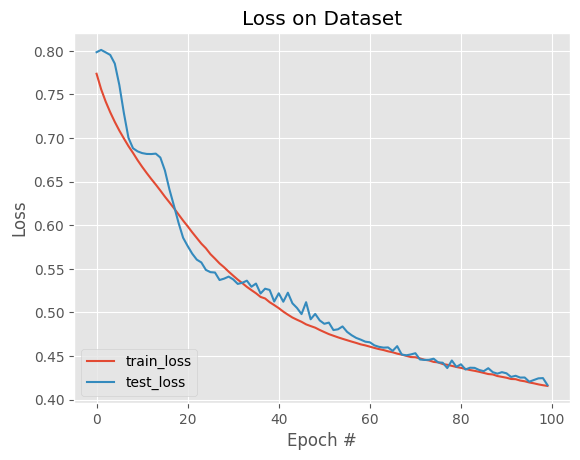

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")

plt.title("Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
torch.save(unet.state_dict(), MODEL_PATH)

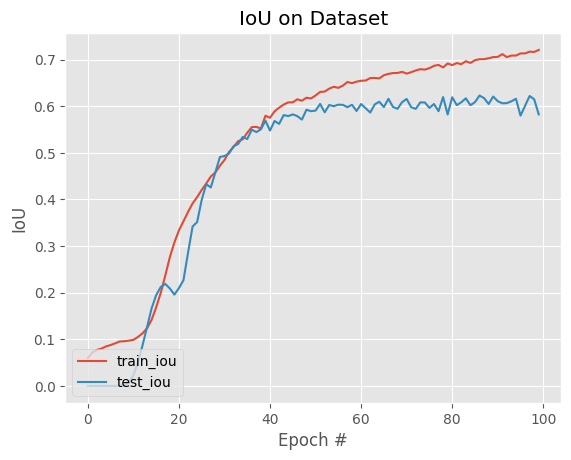

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_iou"], label="train_iou")
plt.plot(H["test_iou"], label="test_iou")
plt.title("IoU on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("IoU")
plt.legend(loc="lower left")

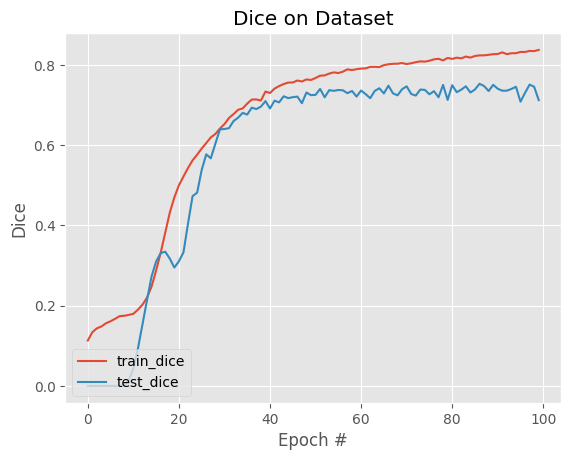

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_dice"], label="train_dice")
plt.plot(H["test_dice"], label="test_dice")
plt.title("Dice on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Dice")
plt.legend(loc="lower left")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import os
from torchvision import transforms

def prepare_plot(origImage, origMask, predMask, imagePath, index, total):
    plot_image(index, 1, origImage, "Image", total)
    plot_image(index, 2, origMask, "Original Mask", total)
    plt.text(0.5, -0.5, imagePath, ha='center', va='center', transform=plt.gca().transAxes)
    plot_image(index, 3, predMask, "Predicted Mask", total)

def plot_image(index, arg1, arg2, arg3, total):
    plt.subplot(total, 3, index*3 + arg1)
    plt.imshow(arg2)
    plt.title(arg3)
    plt.axis('off')

def make_predictions(model, imagePath, index, transform, total):
    model.eval()
    with torch.no_grad():
        image = Image.open(imagePath).convert('L')
        orig = image.copy()
        image = transform(image)
        image = image.numpy()
        filename = imagePath.split(os.path.sep)[-1]
        groundTruthPath = os.path.join(MASK_DATASET_PATH, filename)
        gtMask = Image.open(groundTruthPath).convert('L')
        gtMask = gtMask.point( lambda p: 255 if p > 45 else 0 ).convert('1')
        gtMask = gtMask.resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
        gtMask = np.array(gtMask)

        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        predMask = model(image)
        predMask = predMask[0].detach().cpu()
        predMask = torch.sigmoid(predMask).numpy()[0]
        predMask[predMask >= 0.5] = 255
        predMask[predMask < 0.5] = 1
        predMask = predMask.astype(np.uint8)
        prepare_plot(orig, gtMask, predMask, imagePath, index, total)


[INFO] loading up test image paths...
[INFO] load up model...


<ipython-input-139-1b452ac925bd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(MODEL_PATH))


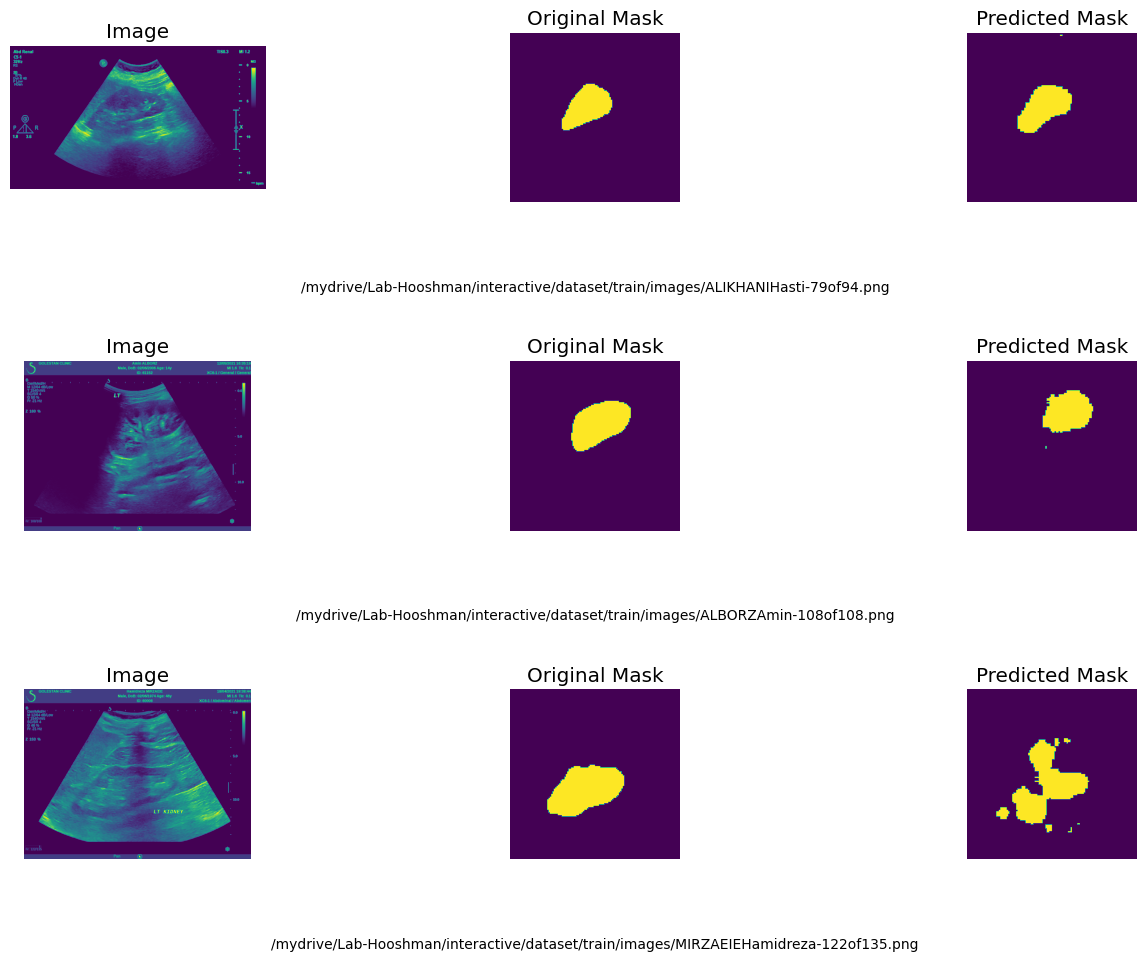

In [ ]:
print("[INFO] loading up test image paths...")
imagePaths = np.random.choice(testImages, size=3)
print("[INFO] load up model...")
unet = UNet().to(DEVICE)
unet.load_state_dict(torch.load(MODEL_PATH))

figure = plt.figure(figsize=(12, 10))

transform = transforms.Compose([transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])

for index, path in enumerate(imagePaths):
    make_predictions(unet, path, index, transform, len(imagePaths))

plt.tight_layout()
plt.savefig(PLOT_PATH_PREDICTION)